In [1]:
pip install tensorflow==2.17.1 keras==3.5.0

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
print(tf.__version__)

2.17.1


In [4]:
# Konfigurasi dataset
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 54

In [5]:
# Load dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    'dataset/train',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    'dataset/validation',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    'dataset/test',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=False
)

class_names = test_ds.class_names

Found 8478 files belonging to 54 classes.
Found 1782 files belonging to 54 classes.
Found 1782 files belonging to 54 classes.


In [6]:
for images, labels in train_ds.take(1):
    print("Image dtype:", images.dtype)
    print("Label dtype:", labels.dtype)

Image dtype: <dtype: 'float32'>
Label dtype: <dtype: 'int32'>


In [7]:
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.1),
    layers.RandomTranslation(0.15, 0.15),
    layers.RandomZoom(0.2),
    layers.RandomFlip('horizontal')
])

normalization = tf.keras.Sequential([
    layers.Rescaling(1./255)
])

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, augment=False):
  # Normalization all datasets.
  ds = ds.map(lambda x, y: (normalization(x), y), 
              num_parallel_calls=AUTOTUNE)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [9]:
train_ds = prepare(train_ds, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [10]:
model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.summary()

c:\laragon\bin\python\python-3.10\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 54)             │         6,966 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,945,398 (49.38 MB)

 Trainable params: 12,945,398 (49.38 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
history = model.fit(
      train_ds,
      epochs=EPOCHS,
      verbose=2,
      validation_data=val_ds)

Epoch 1/10
265/265 - 52s - 198ms/step - accuracy: 0.0730 - loss: 3.7239 - val_accuracy: 0.1818 - val_loss: 3.2669
Epoch 2/10
265/265 - 52s - 196ms/step - accuracy: 0.1559 - loss: 3.2916 - val_accuracy: 0.2581 - val_loss: 2.8729
Epoch 3/10
265/265 - 52s - 196ms/step - accuracy: 0.2162 - loss: 2.9681 - val_accuracy: 0.3440 - val_loss: 2.5094
Epoch 4/10
265/265 - 52s - 195ms/step - accuracy: 0.2663 - loss: 2.7552 - val_accuracy: 0.3636 - val_loss: 2.3635
Epoch 5/10
265/265 - 52s - 196ms/step - accuracy: 0.2994 - loss: 2.6021 - val_accuracy: 0.4242 - val_loss: 2.1372
Epoch 6/10
265/265 - 52s - 195ms/step - accuracy: 0.3227 - loss: 2.4864 - val_accuracy: 0.4343 - val_loss: 2.1093
Epoch 7/10
265/265 - 52s - 195ms/step - accuracy: 0.3429 - loss: 2.4133 - val_accuracy: 0.4467 - val_loss: 1.9924
Epoch 8/10
265/265 - 52s - 196ms/step - accuracy: 0.3693 - loss: 2.3072 - val_accuracy: 0.4658 - val_loss: 1.9545
Epoch 9/10
265/265 - 52s - 195ms/step - accuracy: 0.3854 - loss: 2.2328 - val_accuracy: 

In [13]:
results = pd.DataFrame(history.history)
print(results)

   accuracy      loss  val_accuracy  val_loss
0  0.073013  3.723893      0.181818  3.266916
1  0.155933  3.291598      0.258137  2.872947
2  0.216207  2.968089      0.343996  2.509449
3  0.266336  2.755209      0.363636  2.363516
4  0.299363  2.602132      0.424242  2.137245
5  0.322718  2.486398      0.434343  2.109305
6  0.342887  2.413303      0.446689  1.992433
7  0.369309  2.307182      0.465769  1.954522
8  0.385350  2.232753      0.505050  1.842657
9  0.389832  2.177571      0.501683  1.861351


In [14]:
model.evaluate(test_ds, verbose=2)

56/56 - 3s - 49ms/step - accuracy: 0.4966 - loss: 1.8624


[1.862418293952942, 0.49663299322128296]

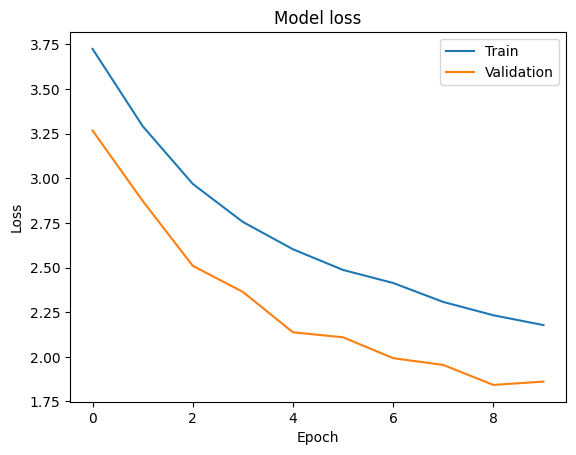

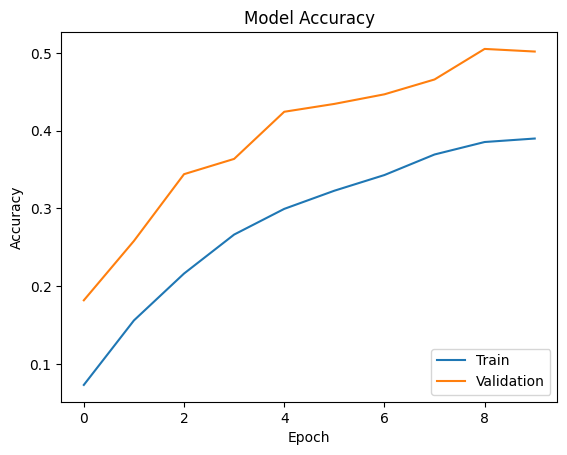

In [15]:
# Plotting the training and testing loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

56/56 - 3s - 49ms/step


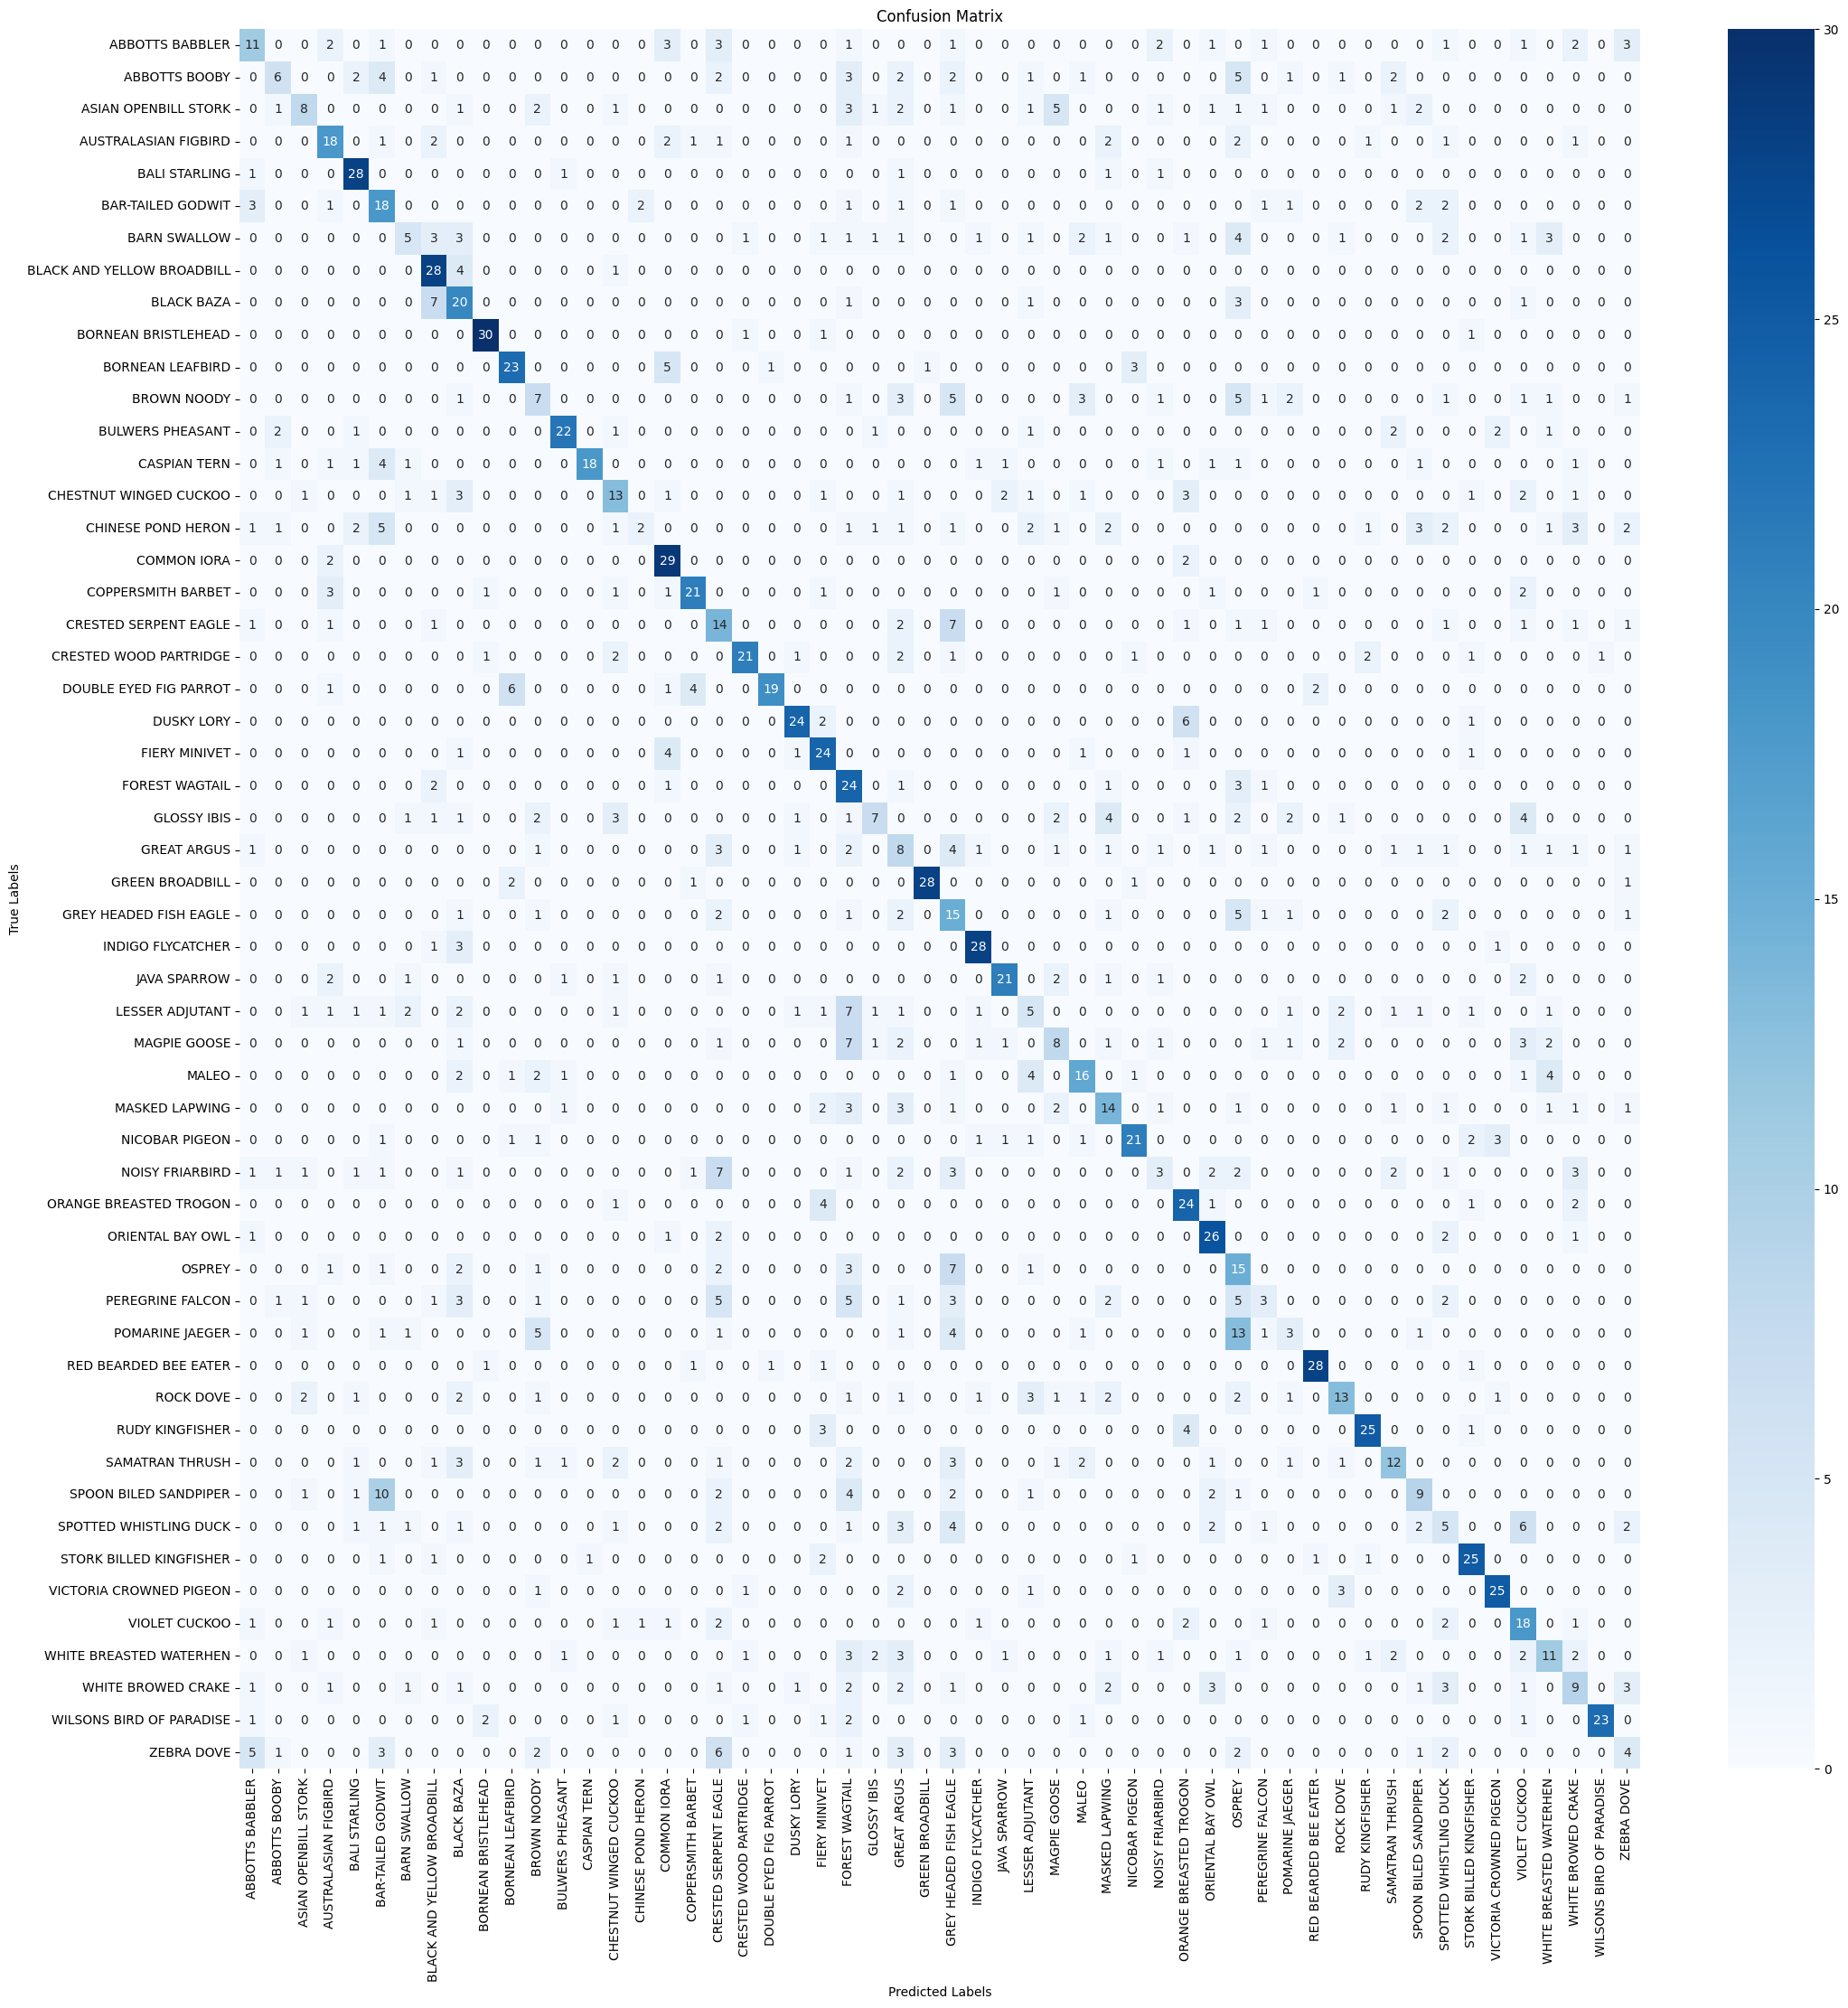

In [16]:
# Confusion matrix dan classification report
true_labels = np.concatenate([y.numpy() for x, y in test_ds])
y_pred_probs = model.predict(test_ds, verbose=2)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(true_labels, y_pred_labels)

plt.figure(figsize=(25, 25))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [17]:
print('Classification Report:')
print(classification_report(true_labels, y_pred_labels, target_names=class_names))

Classification Report:
                            precision    recall  f1-score   support

           ABBOTTS BABBLER       0.39      0.33      0.36        33
             ABBOTTS BOOBY       0.43      0.18      0.26        33
      ASIAN OPENBILL STORK       0.47      0.24      0.32        33
      AUSTRALASIAN FIGBIRD       0.51      0.55      0.53        33
             BALI STARLING       0.70      0.85      0.77        33
         BAR-TAILED GODWIT       0.34      0.55      0.42        33
              BARN SWALLOW       0.36      0.15      0.21        33
BLACK AND YELLOW BROADBILL       0.55      0.85      0.67        33
                BLACK BAZA       0.36      0.61      0.45        33
       BORNEAN BRISTLEHEAD       0.86      0.91      0.88        33
          BORNEAN LEAFBIRD       0.70      0.70      0.70        33
               BROWN NOODY       0.25      0.21      0.23        33
          BULWERS PHEASANT       0.79      0.67      0.72        33
              CASPIAN TE

In [18]:
# Confusion matrix
cm = confusion_matrix(true_labels, y_pred_labels)
labels = class_names  # list nama kelas
results = []

# Inisialisasi untuk rata-rata
total_accuracy = 0
total_precision = 0
total_recall = 0
total_f1 = 0
total_test_data = 0

# Hitung metrik per kelas
for i, label in enumerate(labels):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    total = TP + FN
    total_test_data += total

    # Hitung metrik
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Akumulasi untuk rata-rata
    total_precision += precision
    total_recall += recall
    total_f1 += f1_score

    results.append({
        'Class': label,
        'Total': total,
        'TP': TP,
        'FP': FP,
        'FN': FN,
        'TN': TN,
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1-Score': round(f1_score, 4)
    })

# Hitung rata-rata
n_classes = len(labels)
avg_precision = total_precision / n_classes
avg_recall = total_recall / n_classes
avg_f1 = total_f1 / n_classes

# Tambahkan baris rata-rata ke DataFrame
results.append({
    'Class': 'Average',
    'Total': total_test_data,
    'TP': '-',
    'FP': '-',
    'FN': '-',
    'TN': '-',
    'Precision': round(avg_precision, 4),
    'Recall': round(avg_recall, 4),
    'F1-Score': round(avg_f1, 4)
})

# Buat DataFrame
metrics_df = pd.DataFrame(results)

metrics_df.to_excel('hasilmodel/cnn/confusion_metrics_cnn.xlsx', index=False)

In [19]:
# Confusion matrix
cm = confusion_matrix(true_labels, y_pred_labels)

# Inisialisasi list untuk hasil
labels = class_names
results = []

# Hitung TP, FP, FN, TN untuk setiap kelas
for i, label in enumerate(labels):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    results.append({
        'Class': label,
        'TP': TP,
        'FP': FP,
        'FN': FN,
        'TN': TN
    })

# Buat dataframe
metrics_df = pd.DataFrame(results)

# Tampilkan tabel
print(metrics_df)

metrics_df.to_excel('hasilmodel/cnn/tidaklengkapconfusion_metrics_cnn.xlsx', index=False)

                         Class  TP  FP  FN    TN
0              ABBOTTS BABBLER  11  17  22  1732
1                ABBOTTS BOOBY   6   8  27  1741
2         ASIAN OPENBILL STORK   8   9  25  1740
3         AUSTRALASIAN FIGBIRD  18  17  15  1732
4                BALI STARLING  28  12   5  1737
5            BAR-TAILED GODWIT  18  35  15  1714
6                 BARN SWALLOW   5   9  28  1740
7   BLACK AND YELLOW BROADBILL  28  23   5  1726
8                   BLACK BAZA  20  36  13  1713
9          BORNEAN BRISTLEHEAD  30   5   3  1744
10            BORNEAN LEAFBIRD  23  10  10  1739
11                 BROWN NOODY   7  21  26  1728
12            BULWERS PHEASANT  22   6  11  1743
13                CASPIAN TERN  18   1  15  1748
14      CHESTNUT WINGED CUCKOO  13  18  20  1731
15          CHINESE POND HERON   2   3  31  1746
16                 COMMON IORA  29  20   4  1729
17          COPPERSMITH BARBET  21   8  12  1741
18       CRESTED SERPENT EAGLE  14  44  19  1705
19      CRESTED WOOD

In [20]:
model.save('hasilmodel/cnn/cnn.keras')

In [21]:
# Ambil nama folder dalam dataset/train sebagai label
class_names = sorted(os.listdir('dataset/train'))

# Simpan label ke dalam file labels.txt
with open('hasilmodel/cnn/labelscnn.txt', 'w') as f:
    for label in class_names:
        f.write(f'{label}\n')

print('Label mapping saved to labelscnn.txt')

Label mapping saved to labelscnn.txt
